In [146]:
import os

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import Adam
from torch.distributions import MultivariateNormal, Normal
from torchvision.transforms import ToTensor

from PIL import Image
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from utils import *

In [147]:
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

%load_ext autoreload
%autoreload 2

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Get data

In [148]:
#DEVICE = 'cpu'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [149]:
DATAPATH = 'C:/Users/matan/Documents/data/coil-20-proc'
root_dir = DATAPATH + '/coil-20-proc'
csv_file = 'C:/Users/matan/Documents/data/coil-20-proc/labels.csv'

In [150]:
df = pd.read_csv(csv_file)

In [151]:
class COIL20(Dataset):
    def __init__(self, root_dir, csv_file, transform=None):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.root_dir = root_dir
        self.labels = range(1,21)
        self.objects = ["Rubber duck",
            "Wooden toy 1",
            "Toy car 1",
            "Lucky cat",
            "Anacin",
            "Toy car 2",
            "Wooden toy 2",
            "Johnsons baby powder",
            "Tylenol",
            "Vaseline",
            "Wooden toy 3",
            "Chinese cup",
            "Piggy bank",
            "Connector",
            "Plastic container",
            "Conditioner bottle",
            "Ceramic pot",
            "Teacup",
            "Toy car 3",
            "Philadelphia"]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id, img_label = row['image'], row['label']
        img_filename = self.root_dir + '/' + str(img_id)
        img = Image.open(img_filename)
        if self.transform:
            img = self.transform(img)
        return img, img_label

Number of images in the dataset:  1440
Image shape: torch.Size([1, 128, 128])


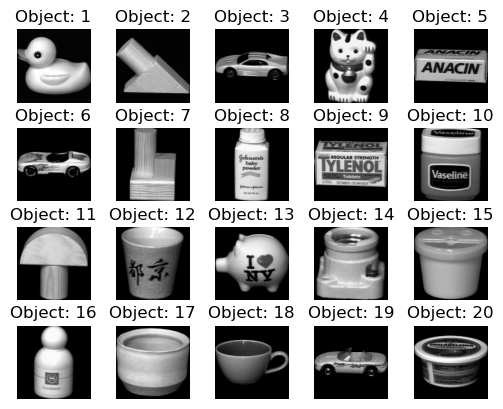

In [152]:
dataset = COIL20(root_dir, csv_file, transform=ToTensor())
print("Number of images in the dataset: ", len(dataset))
img, label = dataset[0]
print("Image shape:", img.shape)

indices = {}
i = 0
while len(indices) < 20:
    _, label = dataset[i]
    if label not in indices.keys():
        indices[label] = i
    i += 1
    
fig = plt.figure()
gs = fig.add_gridspec(4,5, hspace=0.35, wspace=0)
axs = gs.subplots()
for l in range(20):
    img, label = dataset[indices[l+1]]
    assert label == l + 1
    r, c = (l)//5, l%5
    #print("label:", label, "row:", r, "col:", c)
    axs[r,c].imshow(img.permute(1,2,0), cmap=plt.get_cmap('gray'))
    axs[r,c].set_title("Object: " + str(label))
    axs[r,c].axis('off')
plt.show()

# Set parameters

In [153]:
# Hyperparameters
batch_size = 128
lr = 0.001

N = len(dataset)
in_channels = 1
input_size = [in_channels, 128, 128]
latent_dim = 8
n_classes = 20
seed = 11       # Random seed for reproducible results
torch.manual_seed(seed);

In [154]:
# Divide into train, test, and val
test_size = int(0.1*N)
val_size = int(0.1*N)
train_size = N - test_size - val_size

train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])
print("Training images: ", len(train_data))
print("Validation images: ", len(val_data))
print("Test images: ", len(test_data))

#kwargs = {'num_workers': 1, 'pin_memory': True} 
kwargs = {}
train_loader = DataLoader(train_data, batch_size, shuffle=True, **kwargs)
test_loader = DataLoader(test_data, len(test_data), shuffle=True, **kwargs)
val_loader = DataLoader(val_data, len(val_data), **kwargs)

Training images:  1152
Validation images:  144
Test images:  144


# Make and train VAE model

In [186]:
class Encoder(nn.Module):
    def __init__(self, image_channels, latent_dim):
        super(Encoder, self).__init__()
        self.latent_dim = latent_dim
        self.image_channels = image_channels
        kernel_size = 3
        init_channels = 16
        conv_out = [init_channels*4, 16, 16]

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=image_channels, out_channels=init_channels, kernel_size=kernel_size, stride=2, padding=1),
            nn.BatchNorm2d(init_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels=init_channels, out_channels=init_channels*2, kernel_size=kernel_size, stride=2, padding=1),
            nn.BatchNorm2d(init_channels*2),
            nn.ReLU(),
            nn.Conv2d(in_channels=init_channels*2, out_channels=init_channels*4, kernel_size=kernel_size, stride=2, padding=1),
            nn.ReLU()
        )
        self.fc1 = nn.Linear(np.prod(conv_out), 128)
        self.mu = nn.Linear(128, self.latent_dim)
        self.var = nn.Linear(128, self.latent_dim)
        self.activation = nn.LeakyReLU(0.2) #nn.Tanh()
    
    def forward(self, x):
        x = self.conv(x)
        #print(x.shape)
        x = torch.flatten(x, start_dim=1)   # Flatten image
        #print(x.shape)
        x = self.activation(self.fc1(x))
        #print(x.shape)
        return self.mu(x), self.var(x)


class Decoder(nn.Module):
    def __init__(self, image_channels, latent_dim):
        super(Decoder, self).__init__()
        self.latent_dim = latent_dim
        self.image_channels = image_channels

        kernel_size = 3
        init_channels = 16
        #conv_in = [init_channels*2, 32, 32]
        conv_in = [init_channels*4, 16, 16]

        self.fc1 = nn.Linear(self.latent_dim, 128)
        self.fc2 = nn.Linear(128, np.prod(conv_in))
        self.activation = nn.LeakyReLU(0.2) #nn.Tanh()
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=conv_in)

        self.conv = nn.Sequential(
            nn.ConvTranspose2d(4*init_channels, 2*init_channels, kernel_size, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(init_channels*2),
            nn.ReLU(),
            nn.ConvTranspose2d(2*init_channels, init_channels, kernel_size, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(init_channels),
            nn.ReLU(),
            nn.ConvTranspose2d(init_channels, image_channels, kernel_size, stride=2, padding=1, output_padding=1)
            )
        

    def forward(self, z):
        #print("Decoding")
        x = self.activation(self.fc1(z))
        #print(x.shape)
        x = self.activation(self.fc2(x))
        #print(x.shape)
        x = self.unflatten(x)
        #print(x.shape)
        x = self.conv(x)
        #print(x.shape)
        x = torch.sigmoid(x)    # Used tanh before...
        #print(x.shape)
        return x


class Model(nn.Module):
    def __init__(self, image_channels, latent_dim):
        super(Model, self).__init__()
        self.image_channels = image_channels
        self.latent_dim = latent_dim

        self.Encoder = Encoder(self.image_channels, self.latent_dim)
        self.Decoder = Decoder(self.image_channels, self.latent_dim)

    def reparametrization(self, mean, var):
        eps = torch.randn_like(var).to(DEVICE) # Ransom tensor in same shape as var
        z = mean + var*eps
        return z

    def forward(self, x):
        mean, log_var = self.Encoder(x)
        std = torch.exp(0.5 * log_var)
        z = self.reparametrization(mean, std)
        x_hat = self.Decoder(z)
        return x_hat, mean, log_var

    def get_latents(self, x):
        """ Encode data x into latent representations z. """
        mean, log_var = self.Encoder(x)
        std = torch.exp(0.5 * log_var)
        z = self.reparametrization(mean, std)
        return z


def loss_function(x, out, mean, log_var, beta = 1):
    """ Loss function for the model. """

    N = 1152            # Dataset size
    M = x.shape[0]      # Batch size
    #print("x.shape", x.shape, "x_hat.shape", out.shape, "logvar.shape", log_var.shape, "mean.shape", mean.shape)
    x_hat=out
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    #print(reproduction_loss)
    reproduction_loss = ((x - x_hat)**2).sum(dim=(1,2,3))
    #print(reproduction_loss)
    KL_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp(), dim=1)

    #test = torch.sum(1 + log_var - mean.pow(2) - log_var.exp(), dim=1)
    #print("unsummed KL div:", test.shape)
    KL_divergence = KL_divergence * beta

    # SUM FOR BATCH LIKE IN KINGMA
    reproduction_loss = torch.sum(reproduction_loss, dim=0)
    KL_divergence = torch.sum(KL_divergence, dim=0)
    loss = (N/M) * KL_divergence + reproduction_loss

    #print("Loss:", reproduction_loss, KL_divergence)
    #print("repro loss", reproduction_loss.shape, "KL loss", KL_divergence.shape)
    #print(loss)
    return loss, reproduction_loss, KL_divergence

In [187]:
model = Model(input_size[0], latent_dim).to(DEVICE)
optimizer = Adam(model.parameters(), lr=lr)
print(DEVICE)

cuda


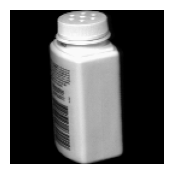

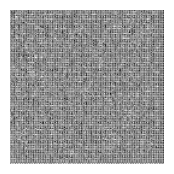

In [182]:
model.eval()
examples = enumerate(test_loader)
with torch.no_grad():
    batch, (x, labels) = next(examples)
    #x = x.view(x.size(0), dim_input)
    x = x.to(DEVICE)
    x_hat, mean, logvar = model(x)

def show_image_in_batch(images, idx):
    images = images.view(images.shape[0], input_size[-2], input_size[-1])
    fig = plt.figure(figsize=(2,2))
    plt.imshow(images[idx].cpu().numpy(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

show_image_in_batch(x, idx=0)
show_image_in_batch(x_hat, idx=0)
loss, r_loss, kl = loss_function(x, x_hat, mean, logvar, beta=1)

In [188]:
def beta_func(step, start=200, stop=400, scale=0.8):
    if step < start:
        return 0
    elif step > stop:
        return scale
    else: 
        return scale * (step - start)/(stop - start)

In [190]:
# Train the model
epochs = 30
validation_loss = []
train_losses = []
train_r_losses = []
train_kl_losses = []
beta_vals = []
step = 0
for epoch in range(epochs):
    model.train()
    loss_this_epoch = 0
    r_loss_this_epoch = 0
    kl_loss_this_epoch = 0
    for batch, (x, label) in enumerate(train_loader):
        batch_size = x.shape[0]
        #x = x.view(batch_size, dim_input)   # Flatten
        x = x.to(DEVICE)

        assert not torch.isnan(x).any()
        optimizer.zero_grad()

        out, mean, logvar = model(x)
        x_hat = out

        if torch.isnan(x_hat.view(-1)).sum().item() != 0:
            print("Number of nans:", torch.isnan(x_hat.view(-1)).sum().item())
            print(x_hat)
        assert not torch.isnan(x_hat).any()
        
        #loss = loss_function(x, out, q_mean, q_log_var)
        beta = 1#beta_func(step)
        loss, r_loss, kl = loss_function(x, x_hat, mean, logvar, beta=beta)
        #print("Loss shape", loss.shape)
        #print(loss)
        loss_this_epoch += loss.item() 
        r_loss_this_epoch += r_loss.item()
        kl_loss_this_epoch += kl.item()
        beta_vals.append(beta)
        step += 1


        loss.backward()
        optimizer.step()

    train_losses.append(loss_this_epoch / ((batch+1)*batch_size))
    train_r_losses.append(r_loss_this_epoch / ((batch+1)*batch_size))
    train_kl_losses.append(kl_loss_this_epoch / ((batch+1)*batch_size))
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", loss_this_epoch / ((batch+1)*batch_size))
    print("\t\t\t\tReproduction loss:", r_loss_this_epoch / ((batch+1)*batch_size) ,"\tKL-div:", kl_loss_this_epoch / ((batch+1)*batch_size))

    model.eval()
    with torch.no_grad():
        for batch, (x, label) in enumerate(val_loader):
            batch_size = x.shape[0]
            #x = x.view(batch_size, dim_input)   # Flatten
            x = x.to(DEVICE)
            x_hat, q_mean, q_log_var = model(x)
            loss, r_loss, kl = loss_function(x, x_hat, mean, logvar, beta=1)
            validation_loss.append(loss.item() / len(val_data))

	Epoch 1 complete! 	Average Loss:  563.6128946940104
				Reproduction loss: 482.21336873372394 	KL-div: 9.044391579098171
	Epoch 2 complete! 	Average Loss:  528.7887708875868
				Reproduction loss: 445.7926534016927 	KL-div: 9.2217894660102
	Epoch 3 complete! 	Average Loss:  502.1623297797309
				Reproduction loss: 415.1116672092014 	KL-div: 9.672296947903103
	Epoch 4 complete! 	Average Loss:  478.58597479926215
				Reproduction loss: 389.04171074761285 	KL-div: 9.949362966749403
	Epoch 5 complete! 	Average Loss:  456.59321763780383
				Reproduction loss: 364.83288913302954 	KL-div: 10.195591714647081
	Epoch 6 complete! 	Average Loss:  442.94726901584204
				Reproduction loss: 351.22901407877606 	KL-div: 10.190917015075684
	Epoch 7 complete! 	Average Loss:  425.2605726453993
				Reproduction loss: 327.5150146484375 	KL-div: 10.860617425706652
	Epoch 8 complete! 	Average Loss:  413.2254808213976
				Reproduction loss: 318.39203559027777 	KL-div: 10.537049823337131
	Epoch 9 complete! 	Av

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


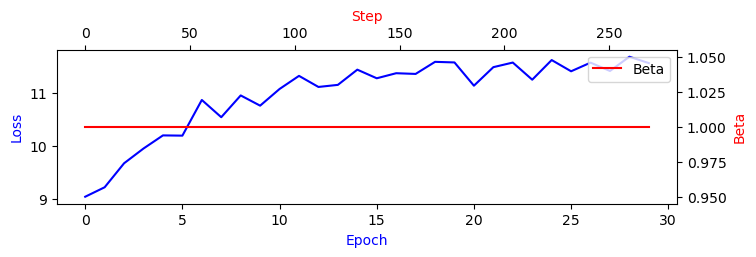

In [201]:
fig = plt.figure(figsize=(8,2))
ax1 = fig.add_subplot(111, label='1')
ax2 = fig.add_subplot(111, label='2', frame_on=False)

ax1.plot(range(epochs), train_kl_losses, color='blue', label = "KL loss (train)")
ax1.set_xlabel("Epoch", color='blue')
ax1.set_ylabel("Loss", color='blue')
plt.legend()

ax2.plot(range(step), beta_vals, color='red', label = "Beta")
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.set_xlabel("Step", color='red')
ax2.set_ylabel("Beta", color='red')
ax2.xaxis.set_label_position('top')
ax2.yaxis.set_label_position('right')
plt.legend()
plt.show()

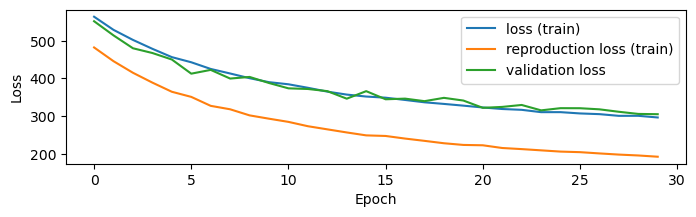

In [192]:
plt.figure(figsize=(8,2))
plt.plot(range(epochs), train_losses, label = "loss (train)")
plt.plot(range(epochs), train_r_losses, label = "reproduction loss (train)")
plt.plot(range(epochs), validation_loss, label = 'validation loss')
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

# Evaluate the model

<Figure size 400x200 with 0 Axes>

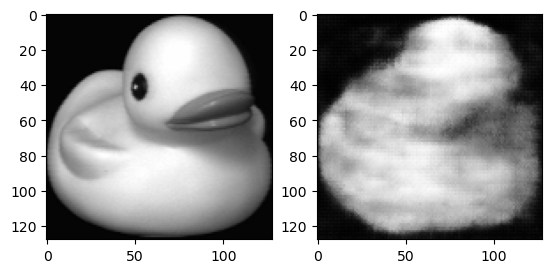

In [194]:
model.eval()

# See reconstruction of an image in the training set
img, label = train_data[900]
img_repro, _, _ = model(img.unsqueeze(0).to(DEVICE))
img_repro = img_repro.reshape(input_size).cpu().detach()
plt.figure(figsize=(4,2))
fig, axs = plt.subplots(1,2)
axs[0].imshow(img.permute(1,2,0), cmap=plt.get_cmap('gray'))
axs[1].imshow(img_repro.permute(1,2,0), cmap=plt.get_cmap('gray'))
plt.show()

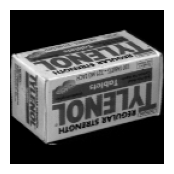

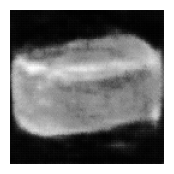

In [200]:
model.eval()
examples = enumerate(test_loader)
with torch.no_grad():
    batch, (x, labels) = next(examples)
    x = x.to(DEVICE)
    x_hat, _, _ = model(x)

def show_image_in_batch(images, idx):
    images = images.view(images.shape[0], input_size[-2], input_size[-1])
    fig = plt.figure(figsize=(2,2))
    plt.imshow(images[idx].cpu().numpy(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

show_image_in_batch(x, idx=0)
show_image_in_batch(x_hat, idx=0)

C:\Users\matan\miniconda3\envs\vae-project\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\matan\miniconda3\envs\vae-project\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1152 samples in 0.001s...
[t-SNE] Computed neighbors for 1152 samples in 0.042s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1152
[t-SNE] Computed conditional probabilities for sample 1152 / 1152
[t-SNE] Mean sigma: 0.975022
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.194199
[t-SNE] KL divergence after 1000 iterations: 0.547246


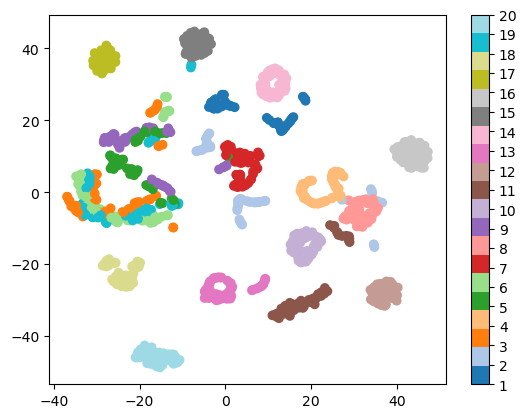

In [196]:
# Make T-SNE plot
plot_latent_space_tsne(model, train_loader)

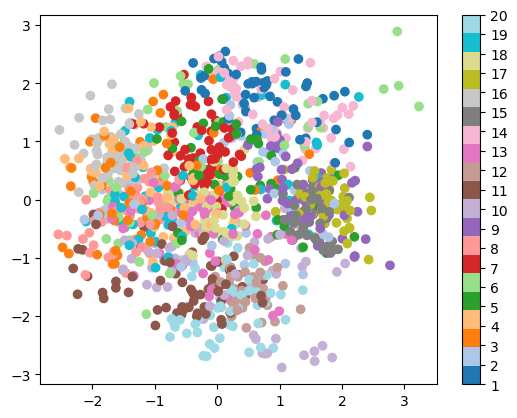

In [197]:
plot_latent_space_pca(model, train_loader, n_batches=200)

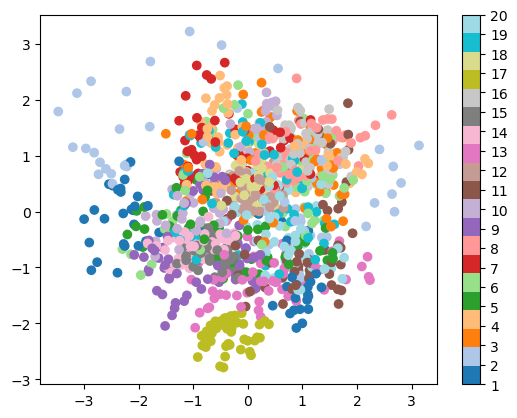

In [198]:
plot_latent_space2d(model, train_loader, n_batches=200)

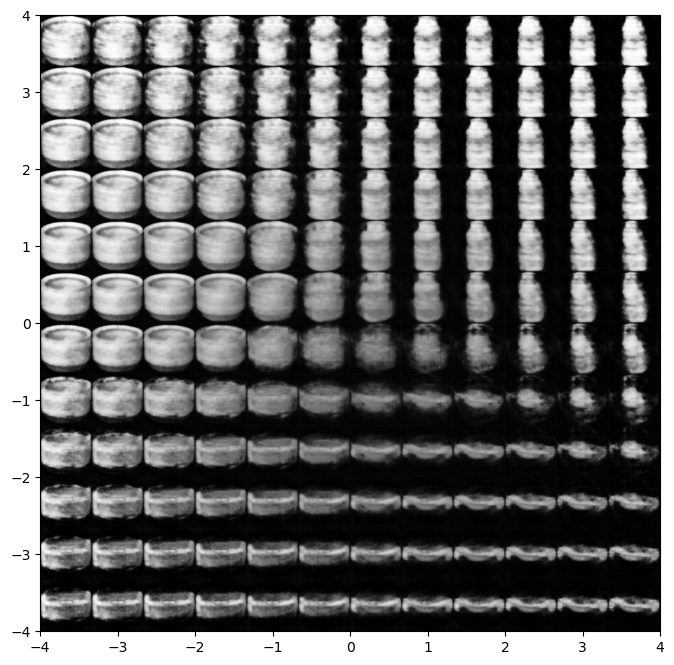

In [199]:
plot_reconstructed(model, ax0=(-4,4), ax1=(-4,4), dims=[1,3], n=12, img_size=input_size[-2:])

# How does it behave on out-of-distribution images?